In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [3]:
from utilities import *

In [4]:
import functools

In [5]:
%matplotlib inline
plt.ioff()
sns.set()
pd.set_option('display.max_columns', 100)

# Part 1: Load the Dataset

In [6]:
def load_data():    
    df = pd.read_csv('dataset.csv')
    df.set_index(['class', 'id_student'],inplace = True)
    return df

In [7]:
df = load_data()

In [8]:
df.head()

code_module code_presentation  date_registration  \
class    id_student                                                    
AAA2013J 11391              AAA             2013J             -159.0   
         28400              AAA             2013J              -53.0   
         31604              AAA             2013J              -52.0   
         32885              AAA             2013J             -176.0   
         38053              AAA             2013J             -110.0   

                     grade_Assessment  grade_Exam gender  \
class    id_student                                        
AAA2013J 11391                   82.4         NaN      M   
         28400                   65.4         NaN      F   
         31604                   76.3         NaN      F   
         32885                   55.0         NaN      F   
         38053                   66.9         NaN      M   

                         highest_education  imd_band age_band  \
class    id_student                                             
AAA2013J 11391            HE Qualification      95.0     55<=   
         28400            HE Qualification      25.0    35-55   
         31604       A Level or Equivalent      55.0    35-55   
         32885          Lower Than A Level      55.0     0-35   
         38053       A Level or Equivalent      85.0    35-55   

                     num_of_prev_attempts  studied_credits disability  \
class    id_student                                                     
AAA2013J 11391                          0              240          N   
         28400                          0               60          N   
         31604                          0               60          N   
         32885                          0               60          N   
         38053                          0               60          N   

                     activity_skew  attention_chi_sq_gof  \
class    id_student                                        
AAA2013J 11391            0.741381              2.736682   
         28400            0.334122              0.763697   
         31604            0.256927              0.327877   
         32885            0.849391              2.519574   
         38053           -0.008823              0.338421   

                     attention_hellinger_squared  attention_total_variation  \
class    id_student                                                           
AAA2013J 11391                          0.385076                   0.401765   
         28400                          0.151137                   0.255698   
         31604                          0.124606                   0.200600   
         32885                          0.361038                   0.403652   
         38053                          0.098247                   0.195052   

                     clicks_dataplus  clicks_dualpane  clicks_externalquiz  \
class    id_student                                                          
AAA2013J 11391                   0.0              0.0                  0.0   
         28400                  10.0              0.0                  0.0   
         31604                   2.0              0.0                  0.0   
         32885                   0.0              0.0                  0.0   
         38053                   7.0              0.0                  0.0   

                     clicks_folder  clicks_forumng  clicks_glossary  \
class    id_student                                                   
AAA2013J 11391                 0.0           193.0              0.0   
         28400                 0.0           417.0              0.0   
         31604                 0.0           634.0              1.0   
         32885                 0.0           194.0              4.0   
         38053                 0.0           875.0              4.0   

                     clicks_homepage  clicks_htmlactivity  \
class    id_student                          

In [9]:
y             = ['grade_Assessment', 'grade_Exam']
X_categorical = ['code_module', 'code_presentation', 'disability', 'gender', 'highest_education', 'age_band']
X_continuous  = df.columns.tolist()
for col in y + X_categorical:
    X_continuous.remove(col)

In [10]:
drop_by_rule(df, df.grade_Assessment.isna())

In [11]:
missing = df.isna().sum()
missing[missing != 0]

grade_Exam                      9006
imd_band                         659
mean_click_time_from_release    2362
mean_click_time_to_close        2362
dtype: int64

In [17]:
continuous_vars = FeaturePlot(df[X_continuous])

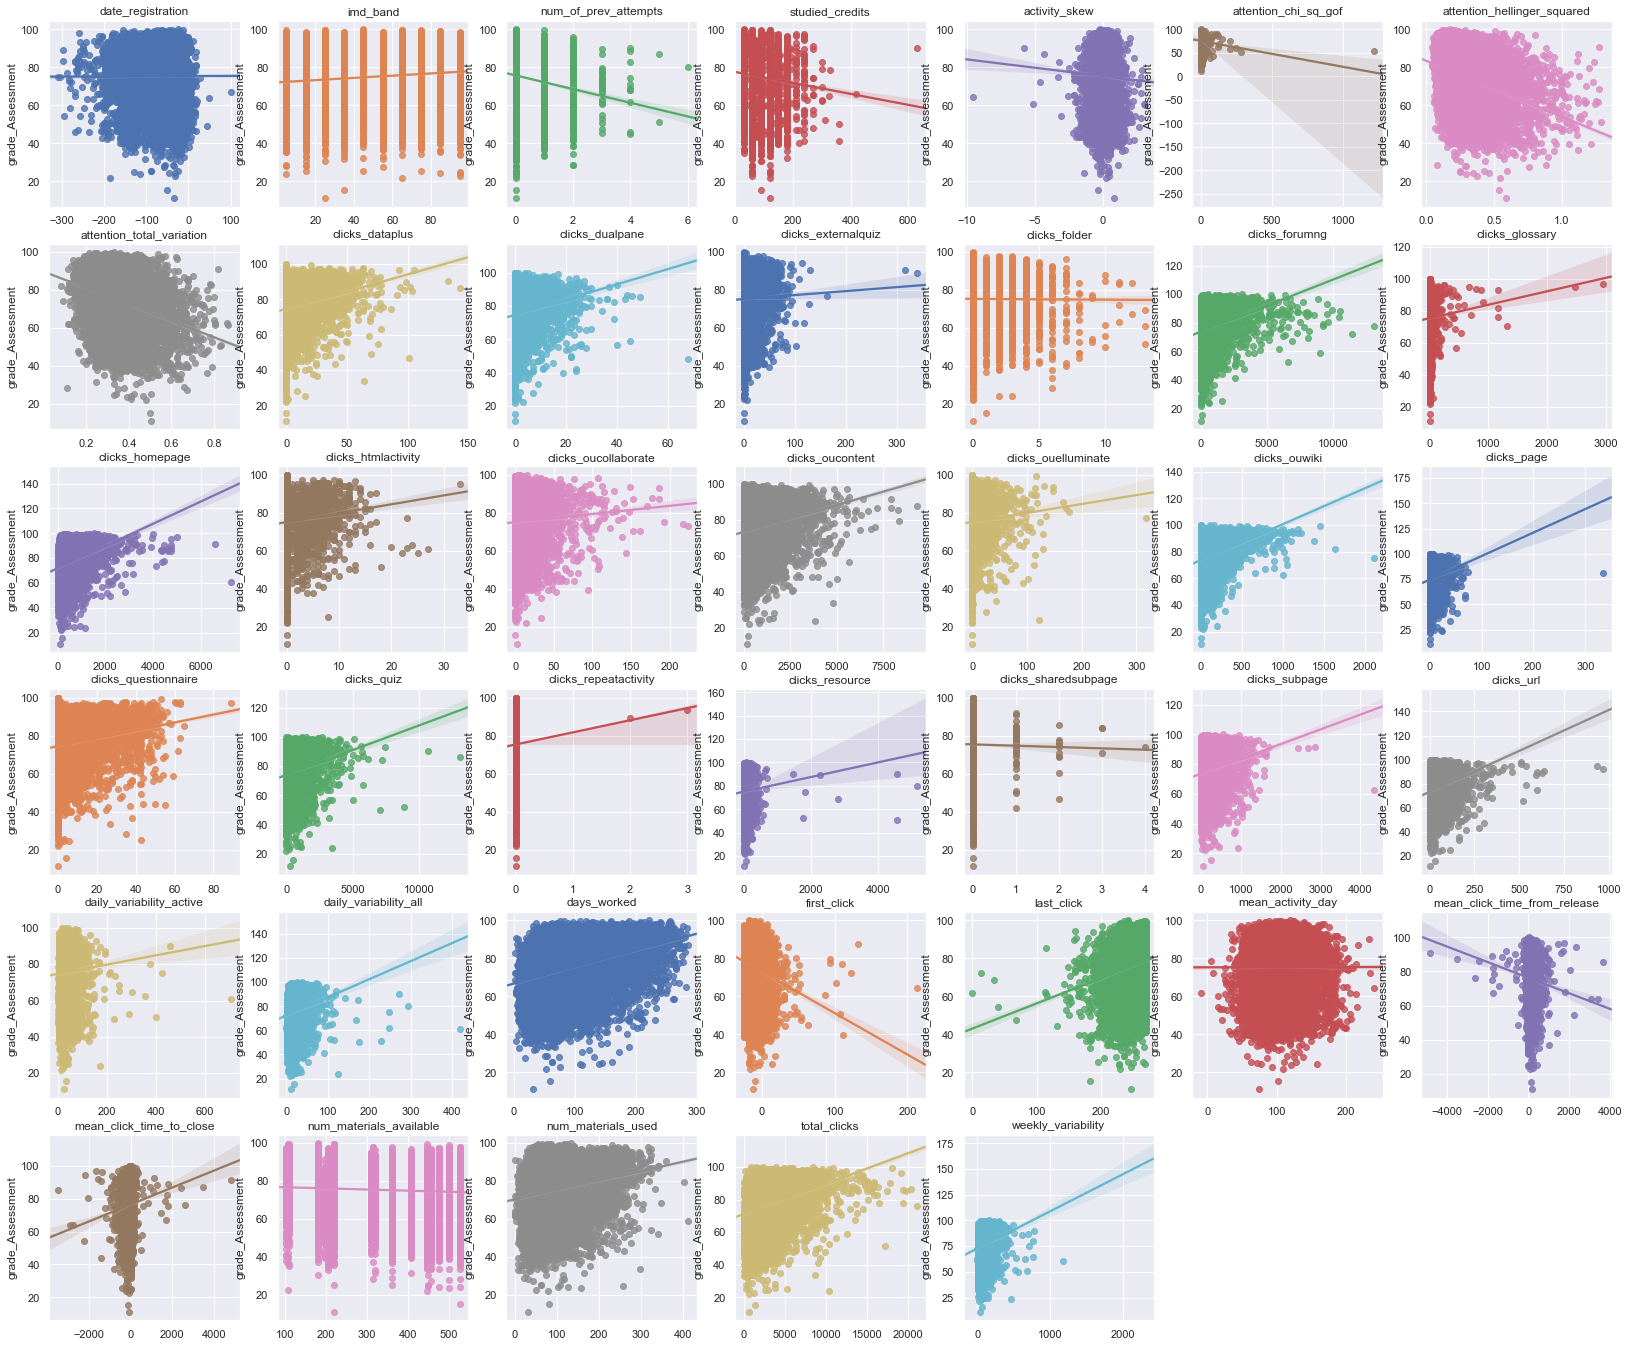

In [18]:
Timer.start()
for col_name, x, ax in continuous_vars:
    sns.regplot(x, df.grade_Assessment, x_ci = 95, ax = ax)

continuous_vars.fig

In [19]:
Timer.end()

50.370 seconds elapsed
